# [Transfer Learning Jasper] Russian Numbers


It is a toy project about ASR model for russian language on small dataset. 

Authors: [@shonenkov](https://www.kaggle.com/shonenkov) & [@artemsolomin](https://www.kaggle.com/artemsolomin)

For students of [Sirius](https://sochisirius.ru/)

# Dependencies

In [2]:
!pip install torchaudio > /dev/null
!pip install inflect==4.1.0  > /dev/null
!pip install toml > /dev/null
!pip install unidecode==1.1.1 > /dev/null
!pip install soundfile > /dev/null
!pip install num2words==0.5.10 > /dev/null
!git clone https://github.com/NVIDIA/DeepLearningExamples > /dev/null

def replace_import_apex(path):
    !cp '{path}' './tmp.py'
    fin = open('./tmp.py', "rt")
    fout = open(path, "wt")
    for line in fin:
        fout.write(line.replace('from apex import amp', '#from apex import amp'))
    fin.close()
    fout.close()
    !rm './tmp.py'

replace_import_apex('./DeepLearningExamples/PyTorch/SpeechRecognition/Jasper/model.py')
replace_import_apex('./DeepLearningExamples/PyTorch/SpeechRecognition/Jasper/parts/features.py')

Cloning into 'DeepLearningExamples'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 8907 (delta 31), reused 71 (delta 18), pack-reused 8794
Receiving objects: 100% (8907/8907), 45.46 MiB | 18.41 MiB/s, done.
Resolving deltas: 100% (4638/4638), done.


In [3]:
import sys
import random
import num2words
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.utils.data import Dataset, DataLoader


SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Data Splitting 

In [4]:
marking = pd.read_csv('../input/russian-numbers-asr/train.csv')
marking['text_number'] = marking['number'].apply(lambda x: num2words.num2words(x, lang='ru'))

def get_stratify_group(row):
    stratify_group = row['gender']
    stratify_group += '_' + str(len(row['text_number'].split()))
    return stratify_group

marking['stratify_group'] = marking.apply(get_stratify_group, axis=1)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
marking.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=marking.index, y=marking['stratify_group'])):
    marking.loc[marking.iloc[val_index].index, 'fold'] = fold_number

marking.head()

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


,path,gender,number,text_number,stratify_group,fold
0,train/e332b996d3.wav,female,157105,сто пятьдесят семь тысяч сто пять,female_6,3
1,train/e25afda49a.wav,female,374554,триста семьдесят четыре тысячи пятьсот пятьдес...,female_7,1
2,train/364f147340.wav,male,688694,шестьсот восемьдесят восемь тысяч шестьсот дев...,male_7,4
3,train/5e0954b206.wav,female,265381,двести шестьдесят пять тысяч триста восемьдеся...,female_7,3
4,train/7130a67690.wav,male,955415,девятьсот пятьдесят пять тысяч четыреста пятна...,male_6,1


# Char Labels

In [5]:
import re

class CharLabels(object):

    def __init__(self):
        self.chars = [
            ' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и',
            'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у',
            'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 
            'я',
        ]
        self.index = {c: i for i, c in enumerate(self.chars)}
        self.re_compile_clean_text = re.compile(r'[^' + ''.join(self.chars[1:])+ r'\s]')

    def __len__(self):
        return len(self.chars)

    def __call__(self, sentence):
        targets = []
        for c in sentence.strip().lower():
            targets.append(self.index[c])
        return targets
    
    def postprocess_indexes(self, preds, max_repeat=1):
        result = []
        last_value = -1
        repeated = 0
        for pred in preds:
            if pred == last_value:
                repeated += 1
            if pred != last_value:
                repeated = 0
                last_value = pred
            if repeated >= max_repeat:
                continue
            result.append(pred)
        return result

    def get_text(self, indexes):
        indexes = self.postprocess_indexes(indexes)
        chars = []
        for index in indexes:
            if index >= len(self.chars):
                continue
            chars.append(self.chars[index])
        return ''.join(chars).strip()

    def clean_text(self, text):
        return re.sub(self.re_compile_clean_text, '', text.lower())

In [6]:
CHAR_LABELS = CharLabels()

CHAR_LABELS.get_text(CHAR_LABELS(marking.iloc[0]['text_number'])), CHAR_LABELS(marking.iloc[0]['text_number'])[:10]

('сто пятьдесят семь тысяч сто пять', [19, 20, 16, 0, 17, 33, 20, 30, 5, 6])

# Dataset Retriever

In [7]:
LABELS_COUNT = len(CHAR_LABELS)
TRAIN_PATH = '../input/russian-numbers-asr/train-sr16k/train-sr16k'

class DatasetRetriever(Dataset):

    def __init__(self, paths, texts, audio_augs=None):
        super().__init__()
        self.paths = paths
        self.texts = texts
        self.audio_augs = audio_augs

    def __getitem__(self, idx):
        path = self.paths[idx].split('/')[-1]
        waveform, sample_rate = torchaudio.load(f'{TRAIN_PATH}/{path}', normalization=True)
        
        ####################
        # Audio Augs: TODO #
        if self.audio_augs:
            waveform = self.audio_augs(waveform)
        ####################

        text = self.texts[idx]

        return {
            'waveform': waveform.squeeze(0),
            'labels': torch.tensor(CHAR_LABELS(text), dtype=torch.int),
            'text': text,
            'path': path,
        }

    def __len__(self) -> int:
        return self.paths.shape[0]

In [8]:
def add_noise(waveform):
    noise = waveform.clone().normal_(0.0, 0.005)
    return waveform + noise

Shape of waveform test: torch.Size([1, 48706])
Sample rate of waveform test: 16000


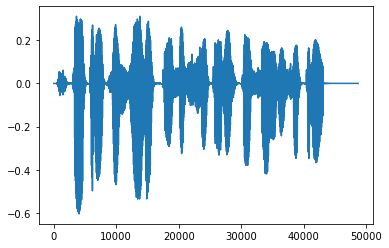

In [9]:
import matplotlib.pyplot as plt

path = '0007c21c23.wav'
waveform, sample_rate = torchaudio.load(f'{TRAIN_PATH}/{path}', normalization=True)
print("Shape of waveform test: {}".format(waveform.size()))
print("Sample rate of waveform test: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

(torch.Tensor, torch.Size([1, 48706]))

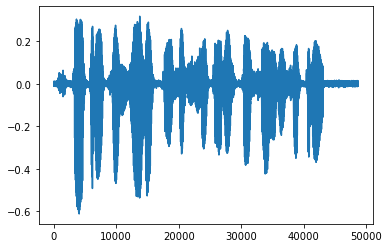

In [10]:
plt.figure()
plt.plot(add_noise(waveform).t().numpy())
type(add_noise(waveform)), add_noise(waveform).size() 

In [11]:
fold_number = 0

train_dataset = DatasetRetriever(
    paths=marking[marking['fold'] != fold_number]['path'].values,
    texts=marking[marking['fold'] != fold_number]['text_number'].values,
    audio_augs=add_noise,
)

validation_dataset = DatasetRetriever(
    paths=marking[marking['fold'] == fold_number]['path'].values,
    texts=marking[marking['fold'] == fold_number]['text_number'].values,
#    audio_augs=add_noise,
)

In [12]:
from torch.nn.utils.rnn import pad_sequence

def collate_audio(batch):
    waveforms = []
    labels = []
    texts = []
    paths = []
    bs = len(batch)
    waveform_sizes = torch.empty(bs, dtype=torch.int)
    label_sizes = torch.empty(bs, dtype=torch.int)
    for i, sample in enumerate(batch):
        waveforms.append(sample['waveform'])
        labels.append(sample['labels'])
        waveform_sizes[i] = sample['waveform'].shape[0]
        label_sizes[i] = sample['labels'].shape[0]
        texts.append(sample['text'])
        paths.append(sample['path'])

    return {
        'waveforms': pad_sequence(waveforms, batch_first=True),
        'labels': pad_sequence(labels, batch_first=True),
        'waveform_sizes': waveform_sizes,
        'label_sizes': label_sizes,
        'texts': texts,
        'paths': paths,
    }

In [13]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=16,
    pin_memory=False,
    drop_last=True,
    num_workers=2,
    collate_fn=collate_audio,
)

In [14]:
for batch in train_loader:
    break
    
batch['waveforms'].shape, batch['labels'].shape

(torch.Size([16, 57521]), torch.Size([16, 61]))

In [15]:
batch['waveform_sizes'], batch['label_sizes']

(tensor([36108, 57521, 43350, 49606, 51743, 48869, 38548, 44972, 48499, 49704,
         50979, 50685, 57462, 55075, 41285, 53973], dtype=torch.int32),
 tensor([35, 61, 42, 52, 56, 50, 33, 47, 50, 51, 52, 50, 57, 56, 42, 53],
        dtype=torch.int32))

In [16]:
batch['texts']

['пятьдесят тысяч сто двадцать четыре',
 'четыреста восемьдесят шесть тысяч шестьсот восемьдесят четыре',
 'семьсот три тысячи пятьсот пятьдесят шесть',
 'девятьсот восемьдесят тысяч девятьсот двадцать шесть',
 'девятьсот семьдесят восемь тысяч девятьсот пятьдесят два',
 'девятьсот сорок пять тысяч шестьсот девяносто пять',
 'двести семнадцать тысяч сто сорок',
 'восемьсот двадцать три тысячи пятьсот сорок три',
 'шестьсот двадцать три тысячи двести девяносто один',
 'пятьсот восемьдесят одна тысяча шестьсот сорок пять',
 'пятьсот восемьдесят девять тысяч двести сорок восемь',
 'семьсот восемьдесят две тысячи восемьсот пятьдесят',
 'четыреста девяносто восемь тысяч восемьсот семьдесят семь',
 'восемьсот пятьдесят четыре тысячи семьсот пятьдесят пять',
 'шестьсот тридцать тысяч сто пятьдесят пять',
 'семьсот восемнадцать тысяч четыреста пятьдесят девять']

# Pretrained Jasper


The Jasper model is an end-to-end neural acoustic model for automatic speech recognition (ASR) that provides near state-of-the-art results on LibriSpeech among end-to-end ASR models without any external data. 

source: https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechRecognition/Jasper

<img src="https://nvidia.github.io/NeMo/_images/quartz_vertical.png" width="500" align="left"/>

In [17]:
import sys

sys.path.insert(0, './DeepLearningExamples/PyTorch/SpeechRecognition/Jasper')

import toml
from collections import OrderedDict
from model import Jasper, JasperEncoderDecoder, JasperEncoder, AudioPreprocessing, CTCLossNM


model_toml = '../input/pretrained-jasper10x5dr-nomask/jasper10x5dr_nomask.toml'
model_definition = toml.load(model_toml)

model_definition['labels']['labels'] = CHAR_LABELS.chars
model_definition['encoder']['convmask'] = True
model_definition['normalize_transcripts'] = False
model_definition['input_eval']['normalize_transcripts'] = False
model_definition['input']['normalize_transcripts'] = False

from copy import deepcopy

ctc_vocab = deepcopy(model_definition['labels']['labels'])
ctc_vocab.append("<BLANK>")

featurizer_config = model_definition['input_eval']
featurizer_config["optimization_level"] = 3

In [18]:
criterion = CTCLossNM(num_classes=len(ctc_vocab))
model = Jasper(feature_config=featurizer_config, jasper_model_definition=model_definition, feat_in=1024, num_classes=len(ctc_vocab))

In [19]:
checkpoint = torch.load(f'../input/pretrained-jasper10x5dr-nomask/jasper_fp16.pt')
preprocessed_checkpoint = OrderedDict()
for key in checkpoint['state_dict'].keys():
    if 'jasper_decoder' in key:
        continue
    preprocessed_checkpoint[key] = checkpoint['state_dict'][key]

model.load_state_dict(preprocessed_checkpoint, strict=False)
model = model.cuda()

In [20]:
audio_preprocessor = AudioPreprocessing(**featurizer_config)

In [21]:
def freeze_until(net, param_name):
    found_name = False
    for name, params in net.named_parameters():
        if name == param_name:
            found_name = True
        params.requires_grad = found_name

freeze_until(model, 'jasper_encoder.encoder.10.conv.0.weight')

# Metrics

In [22]:
from sklearn import metrics

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [23]:
def levenshtein_distance(first, second):
    """
    Compute Levenshtein distance between two array-like objects
    """
    distance = [[0 for _ in range(len(second) + 1)] for _ in range(len(first) + 1)]
    for i in range(len(first) + 1):
        for j in range(len(second) + 1):
            if i == 0:
                distance[i][j] = j
            elif j == 0:
                distance[i][j] = i
            else:
                diag = distance[i - 1][j - 1] + (first[i - 1] != second[j - 1])
                upper = distance[i - 1][j] + 1
                left = distance[i][j - 1] + 1
                distance[i][j] = min(diag, upper, left)
    return distance[len(first)][len(second)]

def calculate_metrics(targets, outputs):
    ser, wer = [], []
    for output, target in zip(
        outputs.argmax(axis=2).cpu().numpy(),
        targets.cpu().numpy()
    ):
        target_text = CHAR_LABELS.get_text(target)
        output_text = CHAR_LABELS.get_text(output)
        ser.append(levenshtein_distance(
            output_text, 
            target_text
        ) / len(target_text))
        wer.append(levenshtein_distance(
            output_text.split(), 
            target_text.split(),
        ) / len(target_text.split()))
    return np.mean(ser), np.mean(wer)

# Training

In [24]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, audio_preprocessor, criterion, device, config):
        self.config = config
        self.epoch = 0
        
        self.base_dir = './'
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.audio_preprocessor = audio_preprocessor
        self.criterion = criterion
        
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, summary_ser, summary_wer = self.train_one_epoch(train_loader)
            
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, ser: {summary_ser.avg:.5f}, wer: {summary_wer.avg:.5f}, time: {(time.time() - t):.5f}')

            t = time.time()
            summary_loss, summary_ser, summary_wer = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, ser: {summary_ser.avg:.5f}, wer: {summary_wer.avg:.5f}, time: {(time.time() - t):.5f}')

            self.model.eval()
            self.save(f'{self.base_dir}/last-checkpoint.bin')
            
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.save(f'{self.base_dir}/best-checkpoint.bin')

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        self.audio_preprocessor.eval();
        summary_loss = AverageMeter()
        summary_wer = AverageMeter()
        summary_ser = AverageMeter()
        t = time.time()
        for step, batch in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ser: {summary_ser.avg:.5f}, wer: {summary_wer.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                t_audio_signal_t = batch['waveforms'].to(self.device)
                t_a_sig_length_t = batch['waveform_sizes'].to(self.device)
                t_transcript_t = batch['labels'].to(self.device)
                t_transcript_len_t = batch['label_sizes'].to(self.device)
                
                t_processed_signal_t, t_processed_sig_length_t = self.audio_preprocessor(t_audio_signal_t, t_a_sig_length_t)
                t_log_probs_t, t_encoded_len_t = self.model.forward((t_processed_signal_t, t_processed_sig_length_t))

                loss = self.criterion(log_probs=t_log_probs_t, targets=t_transcript_t, input_length=t_encoded_len_t, target_length=t_transcript_len_t)
                
                batch_size = t_a_sig_length_t.shape[0]
                
                ser, wer = calculate_metrics(t_transcript_t, t_log_probs_t)
                summary_ser.update(ser, batch_size)
                summary_wer.update(wer, batch_size)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss, summary_ser, summary_wer

    def train_one_epoch(self, train_loader):
        self.model.train()
        self.audio_preprocessor.train();
        summary_loss = AverageMeter()
        summary_wer = AverageMeter()
        summary_ser = AverageMeter()
        t = time.time()
        for step, batch in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ser: {summary_ser.avg:.5f}, wer: {summary_wer.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )

            t_audio_signal_t = batch['waveforms'].to(self.device)
            t_a_sig_length_t = batch['waveform_sizes'].to(self.device)
            t_transcript_t = batch['labels'].to(self.device)
            t_transcript_len_t = batch['label_sizes'].to(self.device)
            
            self.optimizer.zero_grad()
            
            t_processed_signal_t, t_processed_sig_length_t = self.audio_preprocessor(t_audio_signal_t, t_a_sig_length_t)
            t_log_probs_t, t_encoded_len_t = self.model.forward((t_processed_signal_t, t_processed_sig_length_t))
            
            loss = self.criterion(log_probs=t_log_probs_t, targets=t_transcript_t, input_length=t_encoded_len_t, target_length=t_transcript_len_t)

            batch_size = t_a_sig_length_t.shape[0]

            loss.backward()

            self.optimizer.step()
            
            with torch.no_grad():
                ser, wer = calculate_metrics(t_transcript_t, t_log_probs_t)
                summary_ser.update(ser, batch_size)
                summary_wer.update(wer, batch_size)
                summary_loss.update(loss.detach().item(), batch_size)

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss, summary_ser, summary_wer
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [25]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 16 
    n_epochs = 10
    lr = 0.001

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = True  # do scheduler.step after optimizer.step
    validation_scheduler = False  # do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    scheduler_params = dict(
        max_lr=0.001,
        epochs=n_epochs,
        steps_per_epoch=int(len(train_dataset) / batch_size),
        pct_start=0.1,
        anneal_strategy='cos', 
        final_div_factor=10**5
    )

#     SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
#     scheduler_params = dict(
#         mode='min',
#         factor=0.5,
#         patience=1,
#         verbose=False, 
#         threshold=0.0001,
#         threshold_mode='abs',
#         cooldown=0, 
#         min_lr=1e-8,
#         eps=1e-08
#     )
    # --------------------

In [26]:
def run_training():
    device = torch.device('cuda:0')

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=TrainGlobalConfig.batch_size,
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_audio,
    )
    
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_audio,
    )

    fitter = Fitter(
        model=model.to(device),
        audio_preprocessor=audio_preprocessor.to(device),
        criterion=criterion,
        device=device, 
        config=TrainGlobalConfig,
    )
    fitter.fit(train_loader, val_loader)

In [27]:
run_training()

Fitter prepared. Device is cuda:0

2020-07-24T09:48:28.920227
LR: 3.9999999999999996e-05
[RESULT]: Train. Epoch: 0, summary_loss: 52.02014, ser: 0.52204, wer: 1.28676, time: 188.46382
[RESULT]: Val. Epoch: 0, summary_loss: 0.72616, ser: 0.00457, wer: 0.02920, time: 30.40261

2020-07-24T09:52:21.108598
LR: 0.0009999998495717124
[RESULT]: Train. Epoch: 1, summary_loss: 0.51168, ser: 0.21904, wer: 0.80690, time: 184.91142
[RESULT]: Val. Epoch: 1, summary_loss: 1.01855, ser: 0.00606, wer: 0.02513, time: 30.16324

2020-07-24T09:56:02.607582
LR: 0.0009697135283286831
[RESULT]: Train. Epoch: 2, summary_loss: 0.44503, ser: 0.27059, wer: 0.84693, time: 184.57032
[RESULT]: Val. Epoch: 2, summary_loss: 0.16205, ser: 0.02315, wer: 0.16877, time: 30.45623

2020-07-24T10:00:11.451683
LR: 0.0008827728474587917
[RESULT]: Train. Epoch: 3, summary_loss: 0.03892, ser: 0.35879, wer: 1.02255, time: 186.13871
[RESULT]: Val. Epoch: 3, summary_loss: 0.02823, ser: 0.02246, wer: 0.16559, time: 30.69170

2020-07

# Inference

In [28]:
model.load_state_dict(torch.load(f'best-checkpoint.bin')['model_state_dict'])

<All keys matched successfully>

In [29]:
from tqdm import tqdm

def run_inference(model, audio_preprocessor, val_loader):
    result = {
        'reference': [],
        'prediction': [],
        'path': [],
    }
    model.eval();
    audio_preprocessor.eval();
    for batch in tqdm(val_loader, total=len(val_loader)):
        with torch.no_grad():
            t_audio_signal_t = batch['waveforms'].cuda()
            t_a_sig_length_t = batch['waveform_sizes'].cuda()
            result['reference'].extend(batch['texts'])
            result['path'].extend(batch['paths'])

            t_processed_signal_t, t_processed_sig_length_t = audio_preprocessor(t_audio_signal_t, t_a_sig_length_t)
            t_log_probs_t, t_encoded_len_t = model.forward((t_processed_signal_t, t_processed_sig_length_t))
            
            for output in t_log_probs_t.argmax(axis=2).cpu().numpy():
                output_text = CHAR_LABELS.get_text(output)
                result['prediction'].append(output_text)

    return pd.DataFrame(result)

In [30]:
%%time
val_loader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=TrainGlobalConfig.batch_size,
    num_workers=TrainGlobalConfig.num_workers,
    shuffle=False,
    sampler=SequentialSampler(validation_dataset),
    pin_memory=False,
    collate_fn=collate_audio,
)

result = run_inference(model, audio_preprocessor, val_loader)

100%|██████████| 113/113 [00:24<00:00,  4.54it/s]

CPU times: user 17.6 s, sys: 6.86 s, total: 24.4 s
Wall time: 24.9 s


In [42]:
print('{}s per file to make prediction'.format(round(24.9 / 9000, 6)))

0.002767s per file to make prediction


# Result correction

In [31]:
corpus = set(word for string in marking.text_number for word in string.split())

def thousand(number: str) -> str:
    if number == 'одна':
        return 'тысяча'
    elif number in ['две', 'три', 'четыре']:
        return 'тысячи'
    else:
        return 'тысяч'

def correct(text: str) -> str:
    words = list(text.split())
    correct_words = []
    for i, word in enumerate(words):
        if word in corpus:
            correct_words.append(word)        
        else:
            correction = ''
            min_dist = len(word)
            for variant in corpus:
                if levenshtein_distance(word, variant) < min_dist:
                    min_dist = levenshtein_distance(word, variant)
                    correction = variant
            correct_words.append(correction)
                    
        if correct_words[-1][:5] == 'тысяч' and i > 0:
            correct_words[-1] = thousand(words[i - 1])      
        
    return ' '.join(correct_words)

In [32]:
%%time
result['prediction'] = result['prediction'].apply(correct)
result.head()

CPU times: user 5.6 s, sys: 4.62 ms, total: 5.61 s
Wall time: 5.6 s


,reference,prediction,path
0,четыре тысячи двести восемьдесят,четыре тысячи двести восемьдесят,5e39a8735b.wav
1,восемьсот тысяч триста пятьдесят два,восемьсот тысяч триста пятьдесят два,d004a14da0.wav
2,двадцать пять тысяч пятьсот тридцать два,двадцать пять тысяч пятьсот тридцать два,b90381298e.wav
3,девятьсот тридцать девять тысяч сто пять,девятьсот тридцать девять тысяч сто пять,b4c275ce77.wav
4,сто тридцать девять тысяч двести девятнадцать,сто тридцать девять тысяч двести девятнадцать,0f3e842d88.wav


In [ ]:
print('{}s per prediction to make spell correction'.format(round(5.6 / 9000, 6)))

In [33]:
result.to_csv(f'prediction-{fold_number}.csv', index=False)
result.head()

,reference,prediction,path
0,четыре тысячи двести восемьдесят,четыре тысячи двести восемьдесят,5e39a8735b.wav
1,восемьсот тысяч триста пятьдесят два,восемьсот тысяч триста пятьдесят два,d004a14da0.wav
2,двадцать пять тысяч пятьсот тридцать два,двадцать пять тысяч пятьсот тридцать два,b90381298e.wav
3,девятьсот тридцать девять тысяч сто пять,девятьсот тридцать девять тысяч сто пять,b4c275ce77.wav
4,сто тридцать девять тысяч двести девятнадцать,сто тридцать девять тысяч двести девятнадцать,0f3e842d88.wav


# Fold Evaluation

In [34]:
ser, wer = [], []
for prediction, reference in tqdm(zip(result['prediction'], result['reference']), total=result.shape[0]):
    ser.append(levenshtein_distance(
        prediction, 
        reference
    ) / len(reference))
    wer.append(levenshtein_distance(
        prediction.split(), 
        reference.split(),
    ) / len(reference.split()))

100%|██████████| 1800/1800 [00:05<00:00, 348.35it/s]


In [35]:
print('-'*10 + f'fold-{fold_number}' + '-'*10)
print(f'[SER]: {np.mean(ser):.5f}')
print(f'[WER]: {np.mean(wer):.5f}')
print('-'*26)

----------fold-0----------
[SER]: 0.00000
[WER]: 0.00000
--------------------------


In [36]:
mistakes = result[result['reference'] != result['prediction']]
mistakes.shape

(0, 3)

In [37]:
mistakes['dist'] = mistakes.apply(lambda x: levenshtein_distance(x.reference, x.prediction), axis=1)
mistakes.head(10)

ValueError: Wrong number of items passed 3, placement implies 1

In [ ]:
import IPython.display as ipd
ipd.Audio(f'{TRAIN_PATH}/{mistakes.iloc[-1]["path"]}' )

In [ ]:
correct('четыре тысяч двести восмьдесят ')

In [ ]:
mistakes['edited'] = mistakes['prediction'].apply(correct)
mistakes.head()

In [ ]:
mistakes['symbol_dist_after_correction'] = mistakes.apply(lambda x: levenshtein_distance(x.reference, x.edited), axis=1)
mistakes.head()

In [ ]:
left_mistakes = mistakes[mistakes['symbol_dist_after_correction'] != 0]
left_mistakes

# Thank you for reading!